In [ ]:
import torch
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import time
from torchvision import models
import torchvision
from torch.utils.data import random_split
import random
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import copy
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data
from sklearn import decomposition
from sklearn import manifold


# Create transformations for training and test datasets

In [ ]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])


# Download datasets and apply transformations

In [ ]:
train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


# Split training data into validation data

In [ ]:
# training size = 40,000
# Validation size = 10,000

train_size = 40000
val_size = 10000

train_set, val_set = random_split(train_set, [train_size,val_size])



# Create dataloaders for datasets (training, validation, testing)

In [ ]:
batch_size = 100

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=False, pin_memory=True)

val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,
                                          shuffle=False, pin_memory=True)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, pin_memory=True)

# Get Class labels

In [ ]:
# Cifar10 class labels
cifar_classes = test_set.classes
print(cifar_classes)

with open("image_net_classes.txt") as f:
    image_net_classes = eval(f.read())

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
print(image_net_classes)

{0: 'tench, Tinca tinca', 1: 'goldfish, Carassius auratus', 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 3: 'tiger shark, Galeocerdo cuvieri', 4: 'hammerhead, hammerhead shark', 5: 'electric ray, crampfish, numbfish, torpedo', 6: 'stingray', 7: 'cock', 8: 'hen', 9: 'ostrich, Struthio camelus', 10: 'brambling, Fringilla montifringilla', 11: 'goldfinch, Carduelis carduelis', 12: 'house finch, linnet, Carpodacus mexicanus', 13: 'junco, snowbird', 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea', 15: 'robin, American robin, Turdus migratorius', 16: 'bulbul', 17: 'jay', 18: 'magpie', 19: 'chickadee', 20: 'water ouzel, dipper', 21: 'kite', 22: 'bald eagle, American eagle, Haliaeetus leucocephalus', 23: 'vulture', 24: 'great grey owl, great gray owl, Strix nebulosa', 25: 'European fire salamander, Salamandra salamandra', 26: 'common newt, Triturus vulgaris', 27: 'eft', 28: 'spotted salamander, Ambystoma maculatum', 29: 'axolotl, mu

In [ ]:
in_count = {}
for i in range(len(image_net_classes)):
  in_count[image_net_classes[i]] = [0] 

confusion = {}
for i in range(len(cifar_classes)):
  confusion[cifar_classes[i]] = []

In [ ]:
print(confusion)

{'airplane': [], 'automobile': [], 'bird': [], 'cat': [], 'deer': [], 'dog': [], 'frog': [], 'horse': [], 'ship': [], 'truck': []}


In [ ]:
print(in_count)

{'tench, Tinca tinca': [0], 'goldfish, Carassius auratus': [0], 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias': [0], 'tiger shark, Galeocerdo cuvieri': [0], 'hammerhead, hammerhead shark': [0], 'electric ray, crampfish, numbfish, torpedo': [0], 'stingray': [0], 'cock': [0], 'hen': [0], 'ostrich, Struthio camelus': [0], 'brambling, Fringilla montifringilla': [0], 'goldfinch, Carduelis carduelis': [0], 'house finch, linnet, Carpodacus mexicanus': [0], 'junco, snowbird': [0], 'indigo bunting, indigo finch, indigo bird, Passerina cyanea': [0], 'robin, American robin, Turdus migratorius': [0], 'bulbul': [0], 'jay': [0], 'magpie': [0], 'chickadee': [0], 'water ouzel, dipper': [0], 'kite': [0], 'bald eagle, American eagle, Haliaeetus leucocephalus': [0], 'vulture': [0], 'great grey owl, great gray owl, Strix nebulosa': [0], 'European fire salamander, Salamandra salamandra': [0], 'common newt, Triturus vulgaris': [0], 'eft': [0], 'spotted salamander, Amby

In [ ]:
with open("imagenet_classes.txt") as f:
    imagenet_classes = [line.strip() for line in f.readlines()]
print(f"Number of classes => {len(imagenet_classes)}")
imagenet_classes

Number of classes => 1000


['tench, Tinca tinca',
 'goldfish, Carassius auratus',
 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 'tiger shark, Galeocerdo cuvieri',
 'hammerhead, hammerhead shark',
 'electric ray, crampfish, numbfish, torpedo',
 'stingray',
 'cock',
 'hen',
 'ostrich, Struthio camelus',
 'brambling, Fringilla montifringilla',
 'goldfinch, Carduelis carduelis',
 'house finch, linnet, Carpodacus mexicanus',
 'junco, snowbird',
 'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
 'robin, American robin, Turdus migratorius',
 'bulbul',
 'jay',
 'magpie',
 'chickadee',
 'water ouzel, dipper',
 'kite',
 'bald eagle, American eagle, Haliaeetus leucocephalus',
 'vulture',
 'great grey owl, great gray owl, Strix nebulosa',
 'European fire salamander, Salamandra salamandra',
 'common newt, Triturus vulgaris',
 'eft',
 'spotted salamander, Ambystoma maculatum',
 'axolotl, mud puppy, Ambystoma mexicanum',
 'bullfrog, Rana catesbeiana',
 'tree frog, tree-f

# Alexnet Pretrained Model

In [ ]:
alex = models.alexnet(pretrained=True)
alex.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

# GPU Methods

In [ ]:
# Check Primary Device 
def get_device():
  return torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

device = get_device()
print(device)

cuda:0


In [ ]:
torch.cuda.empty_cache()

In [ ]:
def get_free_mem():
  t = torch.cuda.get_device_properties(0).total_memory
  r = torch.cuda.memory_reserved(0)
  a = torch.cuda.memory_allocated(0)
  f = r-a  # free inside reserved
  return t,f

get_free_mem()

(17071734784, 0)

In [ ]:
alex.to(device)
preds = []

## Classify CIFAR10 Images Using AlexNet (GPU)

In [ ]:
from tqdm import tqdm
with torch.no_grad():
  for images, labels in tqdm(test_loader):
    images, labels = images.to(device), labels.to(device) 
    out = alex(images)
    for i in range(batch_size):
      sorted_out, indices = torch.sort(out, descending=True)
      percent = torch.nn.functional.softmax(out, dim=1)[i] * 100
      for index in indices[i][:10]:
        preds.append([ imagenet_classes[index], percent[index].item(), cifar_classes[int(labels[i])] ])



100%|██████████| 100/100 [00:29<00:00,  3.35it/s]


### Get Correlation Matrix

In [ ]:
from collections import Counter
def get_most_common(arr, num_elements=10):
  a_counter = Counter(arr)
  most_common = a_counter.most_common(num_elements)
  ret = []
  for i in range(num_elements):
    ret.append(most_common[i][0])
  return ret, most_common

In [ ]:
y_pred = []
for row in preds:
  y_pred.append(row[0])

common_imagenet_classes, freqs = get_most_common(y_pred)
common_imagenet_classes


['fox squirrel, eastern fox squirrel, Sciurus niger',
 'moving van',
 'milk can',
 'English foxhound',
 'thresher, thrasher, threshing machine',
 'Dandie Dinmont, Dandie Dinmont terrier',
 'wire-haired fox terrier',
 'patas, hussar monkey, Erythrocebus patas',
 'container ship, containership, container vessel',
 'Japanese spaniel']

In [ ]:
freqs

[('fox squirrel, eastern fox squirrel, Sciurus niger', 2741),
 ('moving van', 2513),
 ('milk can', 1798),
 ('English foxhound', 1735),
 ('thresher, thrasher, threshing machine', 1644),
 ('Dandie Dinmont, Dandie Dinmont terrier', 1399),
 ('wire-haired fox terrier', 1354),
 ('patas, hussar monkey, Erythrocebus patas', 1307),
 ('container ship, containership, container vessel', 1287),
 ('Japanese spaniel', 1253)]

In [ ]:
y_predicted = []
y_truth = []
y = []
for row in preds:
  if row[0] in common_imagenet_classes:
    y_predicted.append(row[0])
    y_truth.append(row[-1])
    y.append([row[0], row[-1]])

In [ ]:
len(y_predicted)

17031

In [ ]:
len(y)

17031

In [ ]:
len(y_truth)

17031

In [ ]:
import pandas as pd

df = pd.DataFrame(y, columns = ['Predicted Value', 'Truth Value'])
print(df)

                                         Predicted Value Truth Value
0      fox squirrel, eastern fox squirrel, Sciurus niger         cat
1                                       English foxhound         cat
2        container ship, containership, container vessel         cat
3                                             moving van        ship
4        container ship, containership, container vessel        ship
...                                                  ...         ...
17026                                   Japanese spaniel         dog
17027             Dandie Dinmont, Dandie Dinmont terrier         dog
17028                            wire-haired fox terrier         dog
17029                                           milk can         dog
17030                                   English foxhound  automobile

[17031 rows x 2 columns]


In [ ]:
confusion_matrix = pd.crosstab(df['Predicted Value'], df['Truth Value'], rownames=['Predicted Values (ImageNet Labels)'], colnames=['True Values (CIFAR10 Labels)'])
print (confusion_matrix)

True Values (CIFAR10 Labels)                       airplane  automobile  bird  \
Predicted Values (ImageNet Labels)                                              
Dandie Dinmont, Dandie Dinmont terrier                   25          40   119   
English foxhound                                         34          31   162   
Japanese spaniel                                         25          32   101   
container ship, containership, container vessel         205         112     5   
fox squirrel, eastern fox squirrel, Sciurus niger        91          72   519   
milk can                                                107         283   125   
moving van                                              237         767     8   
patas, hussar monkey, Erythrocebus patas                 11          27   312   
thresher, thrasher, threshing machine                   237         364    18   
wire-haired fox terrier                                  14           5   103   

True Values (CIFAR10 Labels

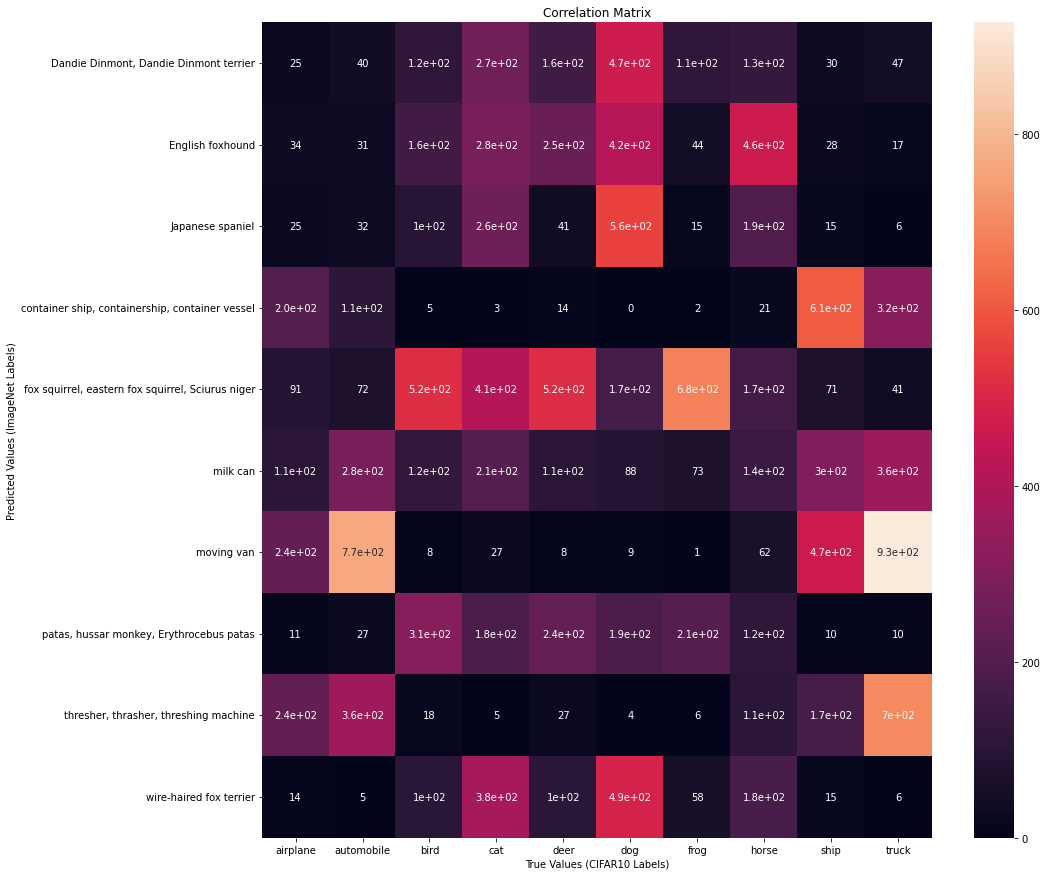

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(15, 15)) 
sns.heatmap(confusion_matrix, annot=True, square=False)
plt.title("Correlation Matrix")
plt.show()
fig.tight_layout()
fig.savefig("part_a_correlation_matrix.png", dpi=199)


#### Debugging (Don't Run)

In [ ]:
frame = df.groupby(['Predicted Value', 'Truth Value']).size().reset_index().rename(columns={0:'Count'})
frame

,Predicted Value,Truth Value,Count
0,"Dandie Dinmont, Dandie Dinmont terrier",airplane,25
1,"Dandie Dinmont, Dandie Dinmont terrier",automobile,40
2,"Dandie Dinmont, Dandie Dinmont terrier",bird,119
3,"Dandie Dinmont, Dandie Dinmont terrier",cat,268
4,"Dandie Dinmont, Dandie Dinmont terrier",deer,158
...,...,...,...
94,wire-haired fox terrier,dog,489
95,wire-haired fox terrier,frog,58
96,wire-haired fox terrier,horse,180
97,wire-haired fox terrier,ship,15


In [ ]:
frame_sorted = frame.sort_values(by=['Count'], ascending=False)
frame_sorted

,Predicted Value,Truth Value,Count
68,moving van,truck,927
60,moving van,automobile,767
88,"thresher, thrasher, threshing machine",truck,702
45,"fox squirrel, eastern fox squirrel, Sciurus niger",frog,682
37,"container ship, containership, container vessel",ship,609
...,...,...,...
82,"thresher, thrasher, threshing machine",cat,5
84,"thresher, thrasher, threshing machine",dog,4
33,"container ship, containership, container vessel",cat,3
35,"container ship, containership, container vessel",frog,2


In [ ]:
x_labels = [v for v in sorted ((df['Predicted Value']).unique())]
x_labels

['Dandie Dinmont, Dandie Dinmont terrier',
 'English foxhound',
 'Japanese spaniel',
 'container ship, containership, container vessel',
 'fox squirrel, eastern fox squirrel, Sciurus niger',
 'milk can',
 'moving van',
 'patas, hussar monkey, Erythrocebus patas',
 'thresher, thrasher, threshing machine',
 'wire-haired fox terrier']

In [ ]:
y_labels = [v for v in sorted ((df['Truth Value']).unique())]
y_labels

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

# Part C

Use one of deep learning frameworks (Pytorch, Tensorflow, Keras) and the AlexNet
pretrained model to extract features for all the images in the CIFAR10 dataset. Use the output of the ’fc6’ layer. Train a linear classifier (logistic regression or linear svm) and evaluate it, using the train, validation and test partitions suggested for the dataset 

In [ ]:
model = models.alexnet(pretrained=True)
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
print(model.classifier[:-5]) #fc6 layer output
print(model.classifier[:-2]) #fc7 layer

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
)
Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
)


## Setup Alexnet for FC6 Layer feature extraction & move to GPU

In [ ]:
model_fc6 = models.alexnet(pretrained=True)

for param in model_fc6.features.parameters():
  param.requires_grad = False 

for param in model_fc6.classifier.parameters():
  param.requires_grad = False 

new_classifier = nn.Sequential(*list(model_fc6.classifier.children())[:-5])
model_fc6.classifier = new_classifier


In [ ]:
model_fc6.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
print(get_free_mem())
torch.cuda.empty_cache()
print(get_free_mem())


(17071734784, 543190528)
(17071734784, 81817088)


In [ ]:
device = get_device()
model_fc6.to(device)
model_fc6.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
from torchsummary import summary
summary(model_fc6, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

## Extract Features from Training Set

In [ ]:
features_train = np.zeros(shape= (train_size, 4096))
labels_train = np.zeros(shape= (train_size))

i=0
with torch.no_grad():
  for images, labels in tqdm(train_loader):
    images, labels = images.to(device), labels.to(device)
    batch_features = model_fc6(images)
    features_train[i * batch_size : (i+1) * batch_size] = batch_features.to('cpu')
    labels_train[i * batch_size : (i+1) * batch_size] = labels.to('cpu')
    i += 1


100%|██████████| 400/400 [01:39<00:00,  4.04it/s]


In [ ]:
print(features_train.shape)
print(labels_train.shape)
torch.cuda.empty_cache()

(40000, 4096)
(40000,)


## Extract Features from Validation Set

In [ ]:
features_val = np.zeros(shape= (val_size, 4096))
labels_val = np.zeros(shape= (val_size))

i=0
with torch.no_grad():
  for images, labels in tqdm(val_loader):
    images, labels = images.to(device), labels.to(device)
    batch_features = model_fc6(images)
    features_val[i * batch_size : (i+1) * batch_size] = batch_features.to('cpu')
    labels_val[i * batch_size : (i+1) * batch_size] = labels.to('cpu')
    i += 1

100%|██████████| 100/100 [00:21<00:00,  4.70it/s]


In [ ]:
print(features_val.shape)
print(labels_val.shape)
torch.cuda.empty_cache()

(10000, 4096)
(10000,)


## Extract Features from Test Set

In [ ]:
test_size = len(test_set)
features_test = np.zeros(shape= (test_size, 4096))
labels_test = np.zeros(shape= (test_size))

i=0
with torch.no_grad():
  for images, labels in tqdm(val_loader):
    images, labels = images.to(device), labels.to(device)
    batch_features = model_fc6(images)
    features_test[i * batch_size : (i+1) * batch_size] = batch_features.to('cpu')
    labels_test[i * batch_size : (i+1) * batch_size] = labels.to('cpu')
    i += 1

100%|██████████| 100/100 [00:21<00:00,  4.70it/s]


In [ ]:
print(features_test.shape)
print(labels_test.shape)
torch.cuda.empty_cache()

(10000, 4096)
(10000,)


## Linear SVC

In [ ]:
from sklearn.svm import LinearSVC
svm_fc6 = LinearSVC(verbose=2)


In [ ]:
svm_fc6.fit(features_train, labels_train)
score = svm_fc6.score(features_train, labels_train)
print(f"Score of Linear SVM on training data {score}")

[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Score of Linear SVM on training data 0.940025


## Run Prediction 

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_cm(y_true, y_pred, display_labels, title="", dim=(15,15)):
  fig, ax = plt.subplots(figsize=dim) 
  ConfusionMatrixDisplay.from_predictions(y_true = y_true, y_pred = y_pred, display_labels = display_labels, ax = ax)
  plt.title(title)
  plt.show()

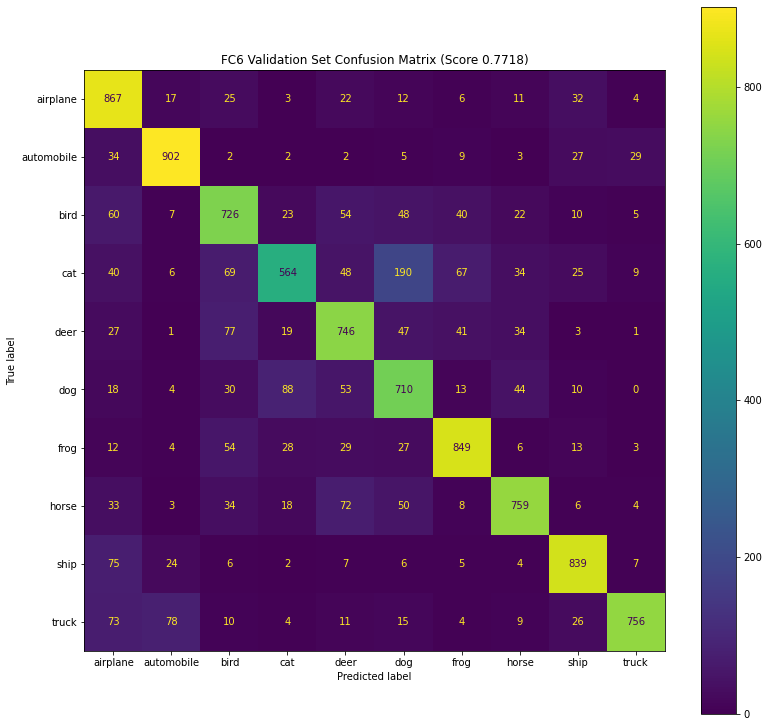

In [ ]:
val_fc6_preds = svm_fc6.predict(features_val)
score_val_6 = svm_fc6.score(features_val, labels_val)

plot_cm(labels_val, val_fc6_preds, cifar_classes, f"FC6 Validation Set Confusion Matrix (Score {score_val_6})", (13,13))




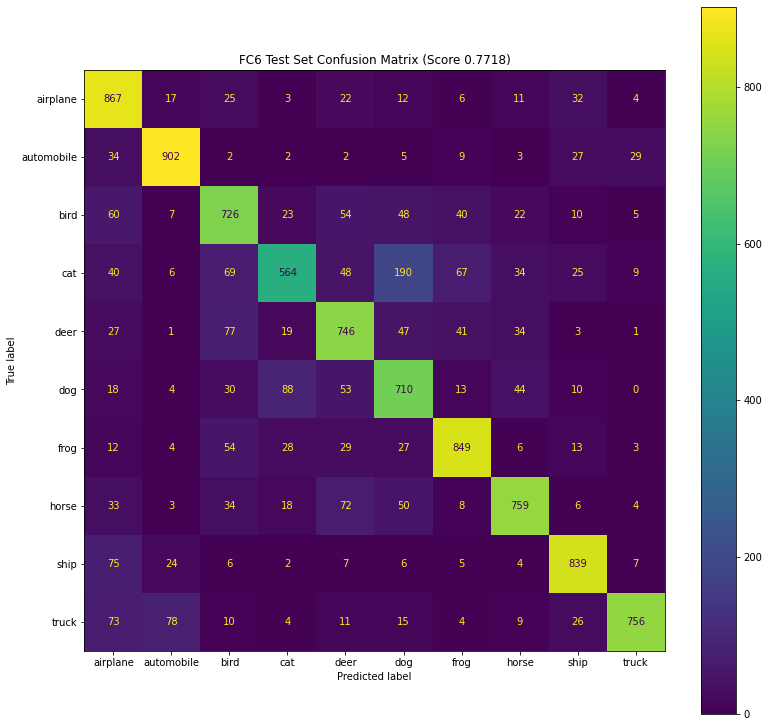

In [ ]:
test_fc6_preds = svm_fc6.predict(features_test)
score_test_6 = svm_fc6.score(features_test, labels_test)
plot_cm(labels_test, test_fc6_preds, cifar_classes, f"FC6 Test Set Confusion Matrix (Score {score_test_6})", (13,13))


# Part D

## Setup alexnet to extract features from fc7 layer

In [ ]:
model_fc7 = models.alexnet(pretrained=True)

for param in model_fc7.features.parameters():
  param.requires_grad = False 

for param in model_fc7.classifier.parameters():
  param.requires_grad = False 

fc7_classifier = nn.Sequential(*list(model_fc7.classifier.children())[:-2])
model_fc7.classifier = fc7_classifier


In [ ]:
torch.cuda.empty_cache()
device = get_device()
model_fc7.to(device)
model_fc7.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## Feature Extraction

In [ ]:
# Extract features from training set
fc7_features_train = np.zeros(shape= (train_size, 4096))
fc7_labels_train = np.zeros(shape= (train_size))

i=0
with torch.no_grad():
  for images, labels in tqdm(train_loader):
    images, labels = images.to(device), labels.to(device)
    batch_features = model_fc7(images)
    fc7_features_train[i * batch_size : (i+1) * batch_size] = batch_features.to('cpu')
    fc7_labels_train[i * batch_size : (i+1) * batch_size] = labels.to('cpu')
    i += 1

torch.cuda.empty_cache()

100%|██████████| 400/400 [01:23<00:00,  4.77it/s]


In [ ]:
# Extract features from validation set
fc7_features_val = np.zeros(shape= (val_size, 4096))
fc7_labels_val = np.zeros(shape= (val_size))

i=0
with torch.no_grad():
  for images, labels in tqdm(val_loader):
    images, labels = images.to(device), labels.to(device)
    batch_features = model_fc7(images)
    fc7_features_val[i * batch_size : (i+1) * batch_size] = batch_features.to('cpu')
    fc7_labels_val[i * batch_size : (i+1) * batch_size] = labels.to('cpu')
    i += 1

torch.cuda.empty_cache()

100%|██████████| 100/100 [00:20<00:00,  4.84it/s]


In [ ]:
# Extract features from test set
test_size = len(test_set)
fc7_features_test = np.zeros(shape= (test_size, 4096))
fc7_labels_test = np.zeros(shape= (test_size))

i=0
with torch.no_grad():
  for images, labels in tqdm(val_loader):
    images, labels = images.to(device), labels.to(device)
    batch_features = model_fc7(images)
    fc7_features_test[i * batch_size : (i+1) * batch_size] = batch_features.to('cpu')
    fc7_labels_test[i * batch_size : (i+1) * batch_size] = labels.to('cpu')
    i += 1

100%|██████████| 100/100 [00:20<00:00,  4.92it/s]


## Support Vector Classifier

In [ ]:
from sklearn.svm import LinearSVC
svm_fc7 = LinearSVC(verbose=2)

svm_fc7.fit(fc7_features_train, fc7_labels_train)
score = svm_fc7.score(fc7_features_train, fc7_labels_train)

print(f"Score of Linear SVM on training data {score}")

[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Score of Linear SVM on training data 0.913875


## Run Prediction 

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_cm(y_true, y_pred, display_labels, title="", dim=(15,15)):
  fig, ax = plt.subplots(figsize=dim) 
  ConfusionMatrixDisplay.from_predictions(y_true = y_true, y_pred = y_pred, display_labels = display_labels, ax = ax)
  plt.title(title)
  plt.show()

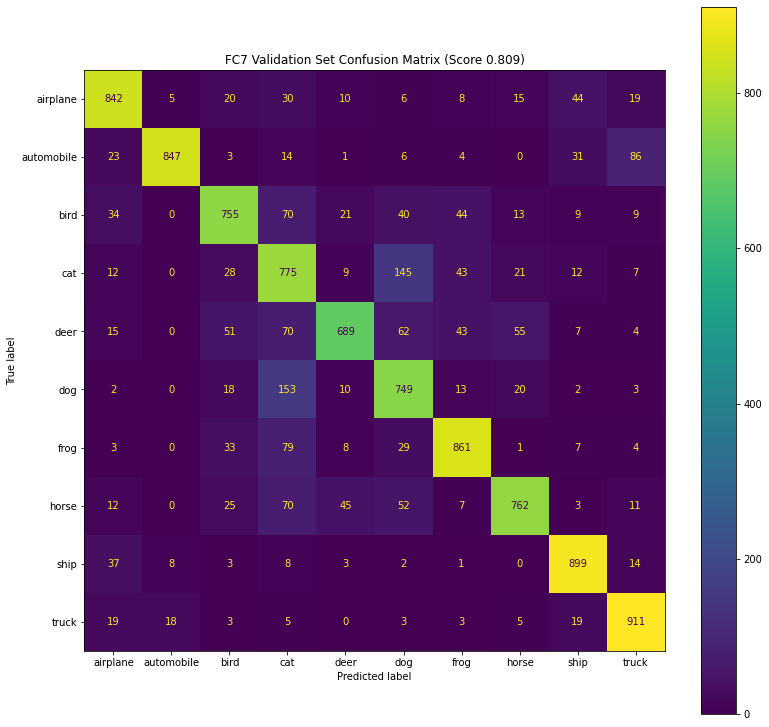

In [ ]:
score_val_7 = svm_fc7.score(fc7_features_val, fc7_labels_val)

val_fc7_preds = svm_fc7.predict(fc7_features_val)
plot_cm(fc7_labels_val, val_fc7_preds, cifar_classes, f"FC7 Validation Set Confusion Matrix (Score {score_val_7})", (13,13))




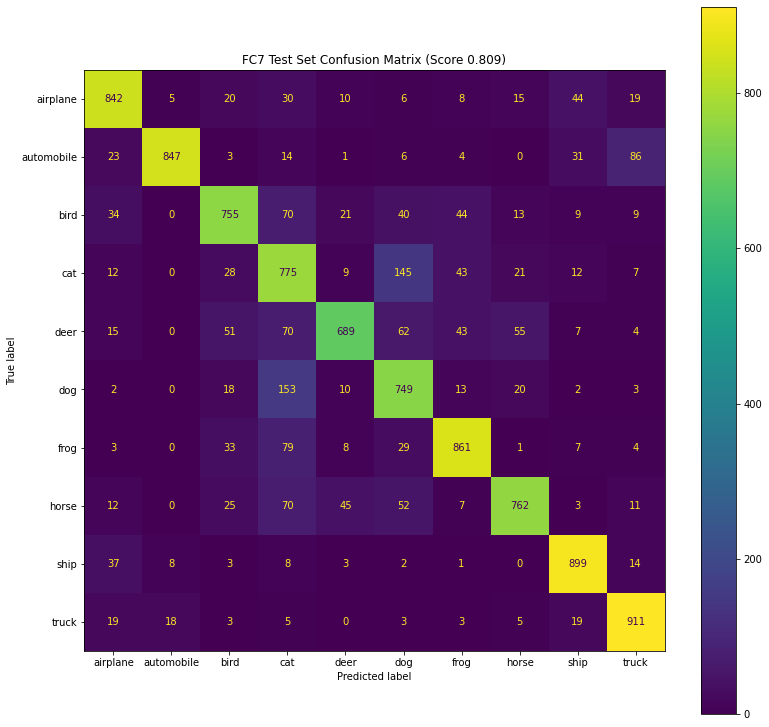

In [ ]:
test_fc7_preds = svm_fc7.predict(fc7_features_test)
score_test_7 = svm_fc7.score(fc7_features_test, fc7_labels_test)

plot_cm(fc7_labels_test, test_fc7_preds, cifar_classes, f"FC7 Test Set Confusion Matrix (Score {score_test_7})", (13,13))
